# CFD Coursework 2: Square Duct

Read DNS data from https://www.cttc.upc.edu/downloads/DuctFlow/

## Imports and Global Settings

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from metpy.calc import vorticity
from metpy.units import units
import xarray

plt.rc('figure', figsize=(10,8)) 
Re_numbers = [300] # one or more from [300, 600, 900, 1200]

## Import Data

### DNS Data

In [16]:
def read_yz_sections(fpath):
    df = pd.read_csv(fpath, delimiter=' ').reset_index()
    df.columns = ['y'] + list(df.iloc[0][1:])
    df = df.drop([0, 1], axis=0).reset_index(drop=True).astype('float')
    return df

dns_data = {}
for Re in Re_numbers:
    section_data_fpath = f'DuctFlow/YZsections/Re{Re}/DuctFlow_Re{Re}_YZ.dat'
    data = read_yz_sections(section_data_fpath)
    dns_data[Re] = data

### StarCCM+ Data

In [17]:
starccm_data = {}
for Re in Re_numbers:
    data = pd.read_csv(f'Re{Re}_data.csv')

    dns_coords = dns_data[Re][['y', 'z']].to_numpy()
    down_sampled = griddata(data[['Y (m)', 'Z (m)']].to_numpy(), data.drop(['Y (m)', 'Z (m)'], axis=1).to_numpy(), dns_coords, method='nearest')

    starccm_df = pd.DataFrame(np.concatenate((down_sampled, dns_coords),axis=1))
    starccm_df.columns = data.columns
    starccm_data[Re] = starccm_df

## Velocity Plots

### DNS Velocity

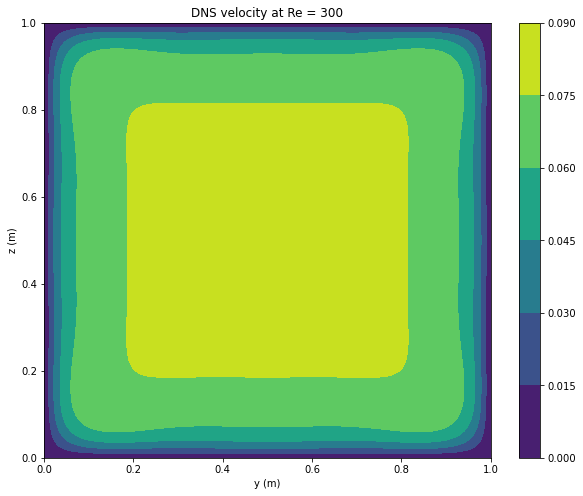

In [62]:
for Re, data in dns_data.items():
    u_tau = Re * 1.48e-5
    plt.tricontourf(data['y'], data['z'], data["<u>"]*u_tau) 
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f"DNS velocity at Re = {Re}")
    plt.colorbar()

### StarCCM Velocity

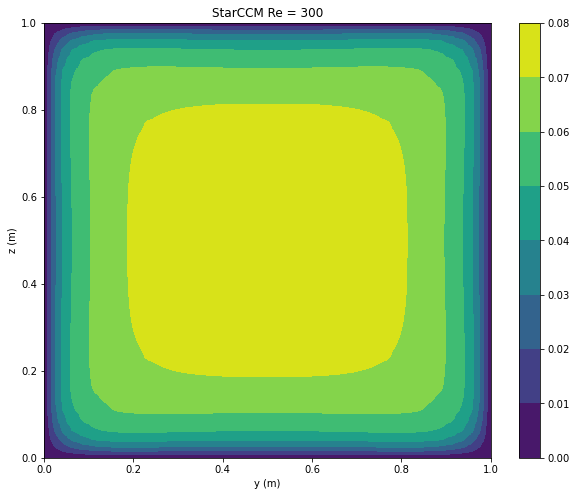

In [25]:
for Re, data in starccm_data.items():
    plt.tricontourf(data['Y (m)'], data['Z (m)'], data['Velocity[i] (m/s)']) 
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f'StarCCM velocity at Re = {Re}')
    plt.colorbar()

### Velocity Errors

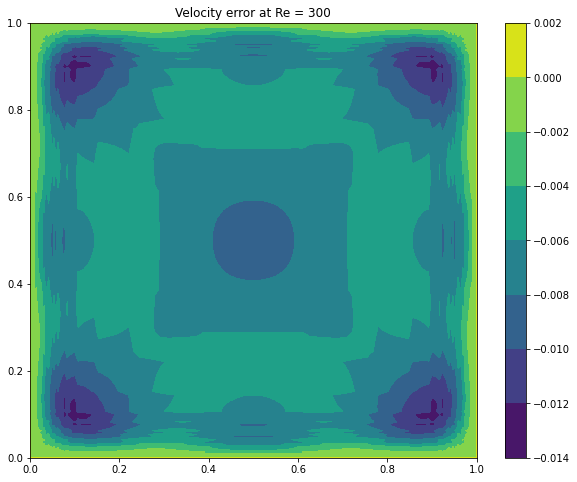

In [56]:
for Re in Re_numbers:
    u_tau = Re * 1.48e-5
    dns_result = dns_data[Re]
    starccm_result = starccm_data[Re]
    # mse = np.mean(np.square(starccm_result['Velocity[i] (m/s)'] - dns_result['<u>'] * u_tau))
    # print(f'Mean Squared Error for Re={Re}: {mse}')

    # Error plot
    error = (starccm_result['Velocity[i] (m/s)'] - dns_result['<u>'] * u_tau)
    plt.title(f'Velocity error at Re = {Re}')
    plt.tricontourf(dns_result['y'], dns_result['z'], error)
    plt.colorbar()

### Mass Flow Rate

In [38]:
for Re in Re_numbers:
    u_tau = Re * 1.48e-5
    dns_result = dns_data[Re]
    starccm_result = starccm_data[Re]

    starccm_u = starccm_result['Velocity[i] (m/s)'].to_numpy()
    dns_u = dns_result['<u>'].to_numpy() * u_tau
    x = dns_result['y'].unique()
    y = dns_result['z'].unique()

    air_density = 1.225
    starccm_interp = RectBivariateSpline(x,y,starccm_u.reshape((x.size,y.size)))
    starccm_mfr = starccm_interp.integral(0,1,0,1) * air_density
    dns_interp = RectBivariateSpline(x,y,dns_u.reshape((x.size,y.size)))
    dns_mfr = dns_interp.integral(0,1,0,1) * air_density

    print(f"Re = {Re}:")
    print(f"StarCCM mass flow rate = {starccm_mfr:.3e}")
    print(f"DNS mass flow rate = {dns_mfr:.3e}")
    print(f"Error: {(starccm_mfr - dns_mfr)/dns_mfr * 100:.2f}%")

Re = 300:
StarCCM mass flow rate = 7.224e-02
DNS mass flow rate = 7.985e-02
Error: -9.53%


## Vorticity

### DNS Vorticity

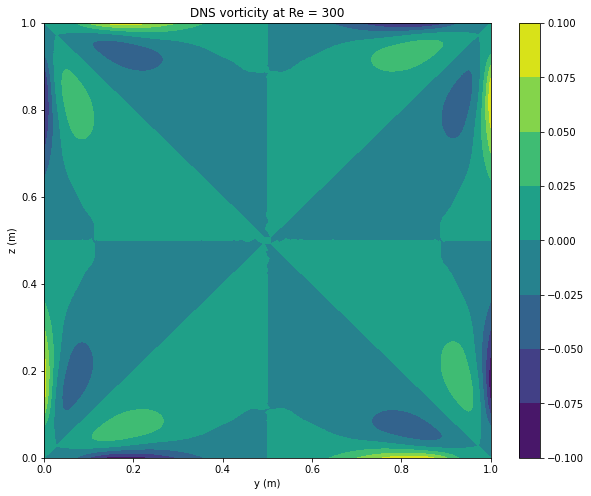

In [44]:
for Re, data in dns_data.items():
    u_tau = Re * 1.48e-5
    v, w = data['<v>'].to_numpy()*u_tau, data['<w>'].to_numpy()*u_tau
    y, z = data['y'].unique(), data['z'].unique()

    v_mesh, w_mesh = v.reshape(y.size,z.size), w.reshape(y.size,z.size)
    v_xarray = xarray.DataArray(v_mesh, attrs={'units': 'm/s'})
    w_xarray = xarray.DataArray(w_mesh, attrs={'units': 'm/s'})

    vort = vorticity(v_xarray, w_xarray, dx = units.Quantity(np.diff(y,n=1), 'm'), dy = units.Quantity(np.diff(z,n=1), 'm'))
    data['vorticity'] = vort.values.reshape(vort.size)

    plt.tricontourf(data['y'], data['z'], data['vorticity'])
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f"DNS vorticity at Re = {Re}")
    plt.colorbar()


### StarCCM Vorticity

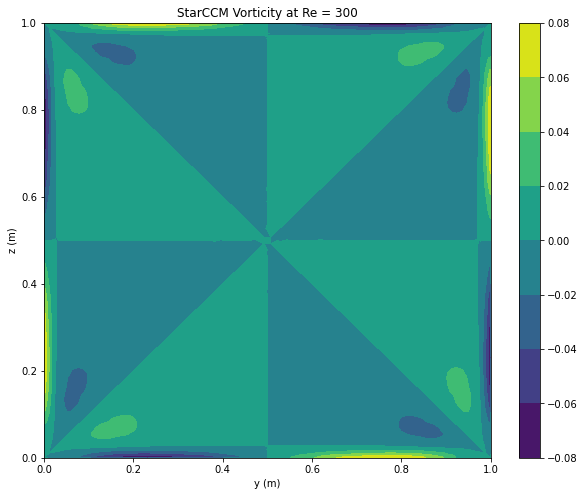

In [40]:
for Re, data in starccm_data.items():
    plt.tricontourf(data['Y (m)'], data['Z (m)'], data['Vorticity[i] (/s)']) 
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f'StarCCM Vorticity at Re = {Re}')
    plt.colorbar()

### Vorticity Errors

Mean Squared Error for Re=300: 6.490069004247671e-05


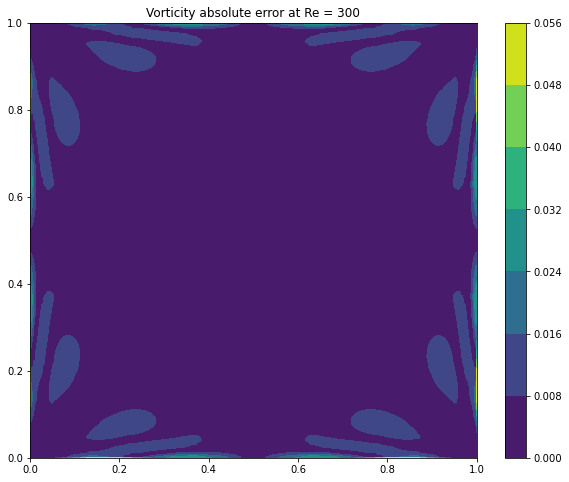

In [60]:
for Re in Re_numbers:
    dns_result = dns_data[Re]
    starccm_result = starccm_data[Re]
    mse = np.mean(np.square(starccm_result['Vorticity[i] (/s)'] - dns_result['vorticity']))
    print(f'Mean Squared Error for Re={Re}: {mse}')

    # Error plot
    error = abs(starccm_result['Vorticity[i] (/s)'] - dns_result['vorticity'])
    plt.title(f'Vorticity absolute error at Re = {Re}')
    plt.tricontourf(dns_result['y'], dns_result['z'], error)
    plt.colorbar()

## Turbulent KE

### DNS Turbulent KE

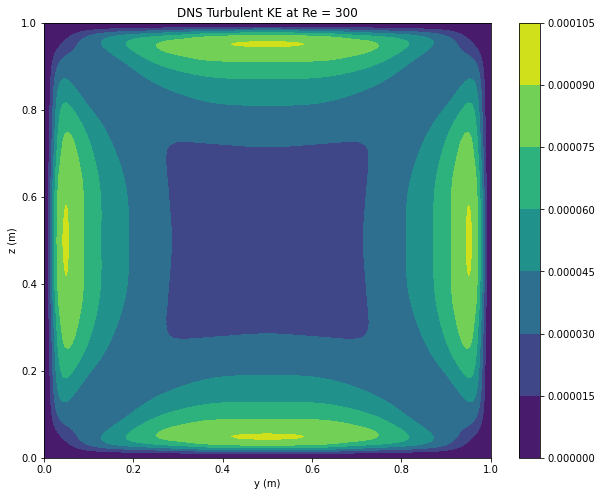

In [46]:
for Re, data in dns_data.items():
    u_tau = Re * 1.48e-5
    data['turbulent_ke'] = 0.5 * (data["<u'u'>"] + data["<v'v'>"] + data["<w'w'>"]) * (u_tau**2)

    plt.tricontourf(data['y'], data['z'], data['turbulent_ke'])
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f"DNS Turbulent KE at Re = {Re}")
    plt.colorbar()

### StarCCM Turbulent KE

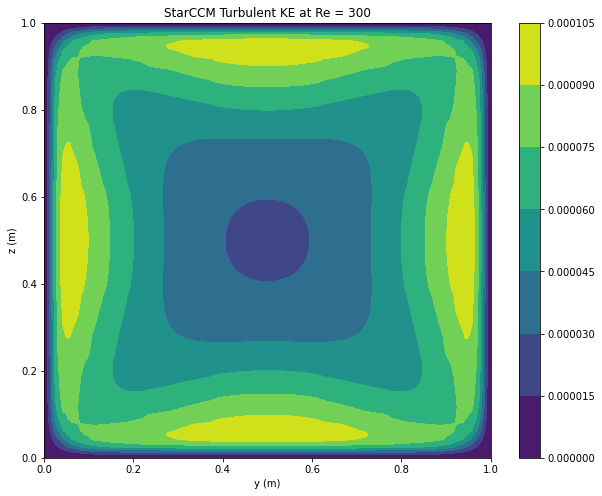

In [48]:
for Re, data in starccm_data.items():
    plt.tricontourf(data['Y (m)'], data['Z (m)'], data['Turbulent Kinetic Energy (J/kg)'])
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    plt.title(f'StarCCM Turbulent KE at Re = {Re}')
    plt.colorbar()

### Turbulent KE Errors

Mean Squared Error for Re=300: 3.3815590202322126e-10


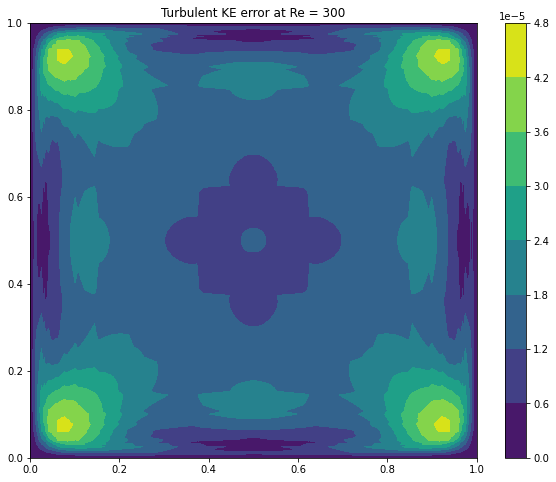

In [57]:
for Re in Re_numbers:
    dns_result = dns_data[Re]
    starccm_result = starccm_data[Re]
    mse = np.mean(np.square(starccm_result['Turbulent Kinetic Energy (J/kg)'] - dns_result['turbulent_ke']))
    print(f'Mean Squared Error for Re={Re}: {mse}')

    # Error plot
    error = (starccm_result['Turbulent Kinetic Energy (J/kg)'] - dns_result['turbulent_ke'])
    plt.title(f'Turbulent KE error at Re = {Re}')
    plt.tricontourf(dns_result['y'], dns_result['z'], error)
    plt.colorbar()

## Profiles

In [58]:
# def read_profile_data(fpath):
#     df = pd.read_csv(fpath, delimiter=' ', header=None)
#     columns = df.iloc[0].dropna().values[1:]
#     df = df.iloc[2:].dropna(axis=1)
#     df.columns = columns
#     df = df.astype(float)
#     return df


# for Re in Re_numbers:
#     profile_dir = f'DuctFlow/profiles/Re{Re}/'
#     profile_fpaths = [profile_dir + file_dir for file_dir in os.listdir(profile_dir)]
#     profile_fpaths.sort()
#     u_tau = Re * 1.48e-5

#     for file in profile_fpaths:
#         profile_data = read_profile_data(file)
#         plt.plot(profile_data['y'].values, profile_data["<u>"].values * u_tau, label=f'z = {profile_data["z"].values[0]} m')

#     plt.ylabel("u")
#     plt.xlabel('y (m)')
#     plt.title(f"Plot of u at Re = {Re}")
#     plt.legend()
